# Data set processing

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('./data_set/suicide_rates_socioeconomic_factors.csv')

data = data.dropna()

def safe_to_numeric(x):
    try:
        return pd.to_numeric(x)
    except ValueError:
        return x

data = data.apply(lambda x: safe_to_numeric(x) if x.dtype == 'object' else x)


df = pd.DataFrame({'Year': data['Year'],
                    'RegionName': data['RegionName'],
                    'RegionCode':  data['RegionCode'],
                    'CountryName': data['CountryName'],
                    'CountryCode': data['CountryCode'],
                    'Sex': data['Sex'],
                    'SuicideCount': data['SuicideCount'],
                    'Population': data['Population'],
                    'GDPPerCapita': data['GDPPerCapita'],
                    'GNIPerCapita': data['GNIPerCapita'],
                    'EmploymentPopulationRatio': data['EmploymentPopulationRatio'],
                    'InflationRate': data['InflationRate']})

df = df.sort_values(by='Year')
df = df.reset_index(drop=True)
df.index = df.index + 1

display(df)

# convert categorical data to numerical using LabelEncoder
label_encoders = {}
for column in ['RegionCode', 'RegionName', 'CountryCode', 'CountryName', 'Sex']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# features and target variable
X = data[['CountryCode', 'Year', 'Sex', 'GDPPerCapita', 'GNIPerCapita', 'InflationRate', 'EmploymentPopulationRatio']]
y = data['SuicideCount']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

,Year,RegionName,RegionCode,CountryName,CountryCode,Sex,SuicideCount,Population,GDPPerCapita,GNIPerCapita,EmploymentPopulationRatio,InflationRate
1,1991,Europe,EU,Belgium,BEL,Male,1278,10004486.0,21041.66065,19740.0,45.831,3.215311
2,1991,Oceania,OA,Australia,AUS,Female,482,17284036.0,18859.40796,17120.0,57.094,3.176675
3,1991,Oceania,OA,Australia,AUS,Male,1806,17284036.0,18859.40796,17120.0,57.094,3.176675
4,1991,Europe,EU,Spain,ESP,Female,777,38966376.0,14811.90282,14310.0,41.664,5.934213
5,1991,Europe,EU,Austria,AUT,Male,1299,7754891.0,22410.91177,20600.0,53.930,3.337427
...,...,...,...,...,...,...,...,...,...,...,...,...
4694,2022,Europe,EU,Sweden,SWE,Male,898,10486941.0,56424.28470,67630.0,61.343,8.369291
4695,2022,Europe,EU,Estonia,EST,Male,147,1348840.0,28247.09599,45200.0,61.512,19.398263
4696,2022,Europe,EU,Estonia,EST,Female,46,1348840.0,28247.09599,45200.0,61.512,19.398263
4697,2022,Asia,AS,Singapore,SGP,Male,237,5637022.0,82807.62906,107070.0,68.694,6.121060


# KNN prediction

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [39]:
params = knn.get_params()
print("Model Parameters:", params)

# Calculate and print training accuracy (R-squared)
train_score = knn.score(X_train, y_train)
print("Train Accuracy (R-squared):", train_score)

# Optionally, evaluate the model on test data
test_score = knn.score(X_test, y_test)
print("Test Accuracy (R-squared):",test_score)

Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
Train Accuracy (R-squared): 0.6277416014672117
Test Accuracy (R-squared): 0.48061001752260435


In [40]:
def get_average_factors(country_code, end_year):
    year_range = range(end_year - 5, end_year)
    subset = data[(data['CountryCode'] == country_code) & (data['Year'].isin(year_range))]
    
    if subset.empty:
        print(f'No data available for the specified range {year_range}. Using the most recent available data.')
        subset = data[(data['CountryCode'] == country_code) & (data['Year'] <= end_year)]
        if subset.empty:
            return [0, 0, 0, 0]  # Default values if no data is available

    avg_gdp = subset['GDPPerCapita'].mean()
    avg_gni = subset['GNIPerCapita'].mean()
    avg_inflation = subset['InflationRate'].mean()
    avg_employment = subset['EmploymentPopulationRatio'].mean()
    
    return [avg_gdp, avg_gni, avg_inflation, avg_employment]

In [41]:
def predict_suicides(country, year, sex):
    country_code = label_encoders['CountryCode'].transform([country])[0]
    sex_code = label_encoders['Sex'].transform([sex])[0]
    
    # Check if specific data is available for the country, year, and sex
    specific_data = data[(data['CountryCode'] == country_code) & 
                         (data['Year'] == year) & 
                         (data['Sex'] == sex_code)]
    
    if not specific_data.empty:
        gdp_per_capita = specific_data['GDPPerCapita'].values[0]
        gni_per_capita = specific_data['GNIPerCapita'].values[0]
        inflation_rate = specific_data['InflationRate'].values[0]
        employment_ratio = specific_data['EmploymentPopulationRatio'].values[0]
        input_data =  pd.DataFrame([[country_code, year, sex_code, gdp_per_capita, gni_per_capita, inflation_rate, employment_ratio]], columns=X.columns)

    else:
        avg_factors = get_average_factors(country_code, year)
        input_data = pd.DataFrame([[country_code, year, sex_code] + avg_factors], columns=X.columns)
    
    input_data_scaled = scaler.transform(input_data)
    prediction = knn.predict(input_data_scaled)
    return prediction[0]


In [42]:
# Example prediction for France year 2023
country = 'FRA'
year = 2023
predicted_suicides_male = predict_suicides(country, year, 'Male')
predicted_suicides_female = predict_suicides(country, year, 'Female')

print(f"In {year}, in {country}, there will be an average number of {predicted_suicides_male:.2f} suicides for men and {predicted_suicides_female:.2f} suicides for women.")


In 2023, in FRA, there will be an average number of 3974.90 suicides for men and 986.20 suicides for women.


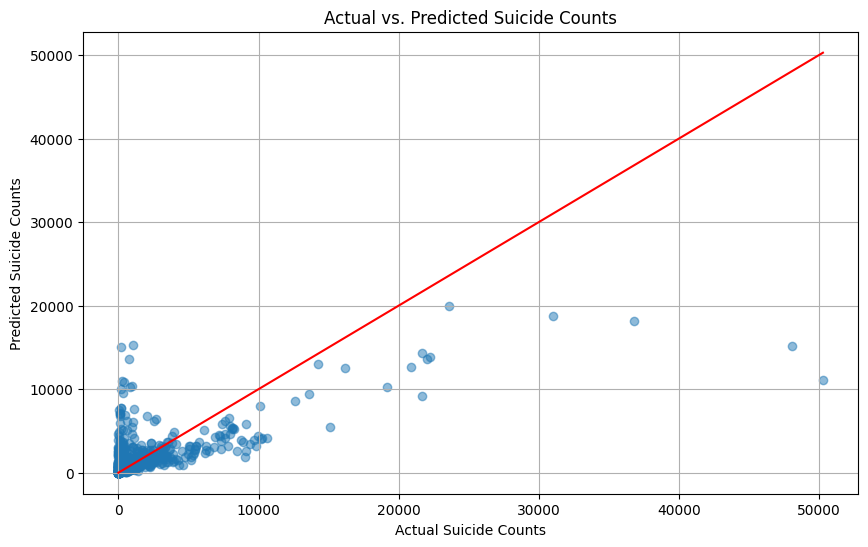

In [43]:
# Scatter Plot of Actual vs. Predicted Suicides
y_pred = knn.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Suicide Counts')
plt.ylabel('Predicted Suicide Counts')
plt.title('Actual vs. Predicted Suicide Counts')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.grid(True)
plt.show()


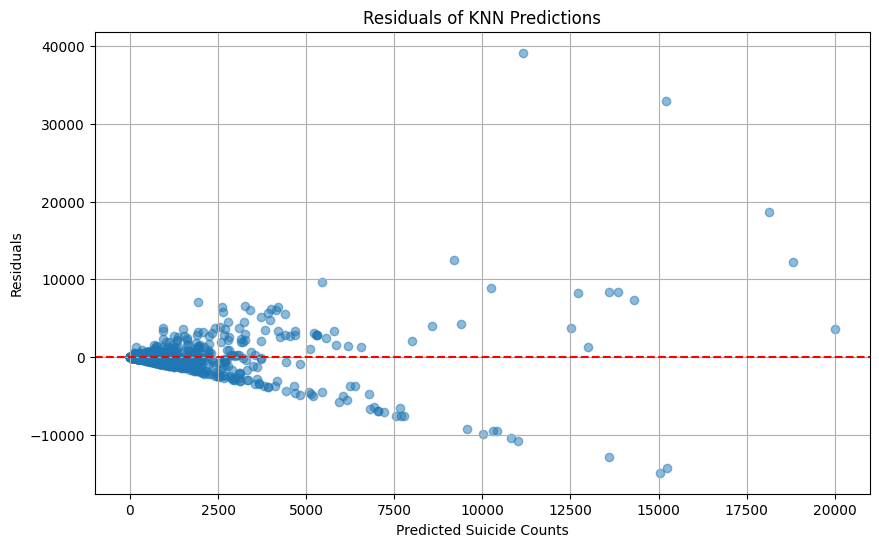

In [44]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Suicide Counts')
plt.ylabel('Residuals')
plt.title('Residuals of KNN Predictions')
plt.grid(True)
plt.show()

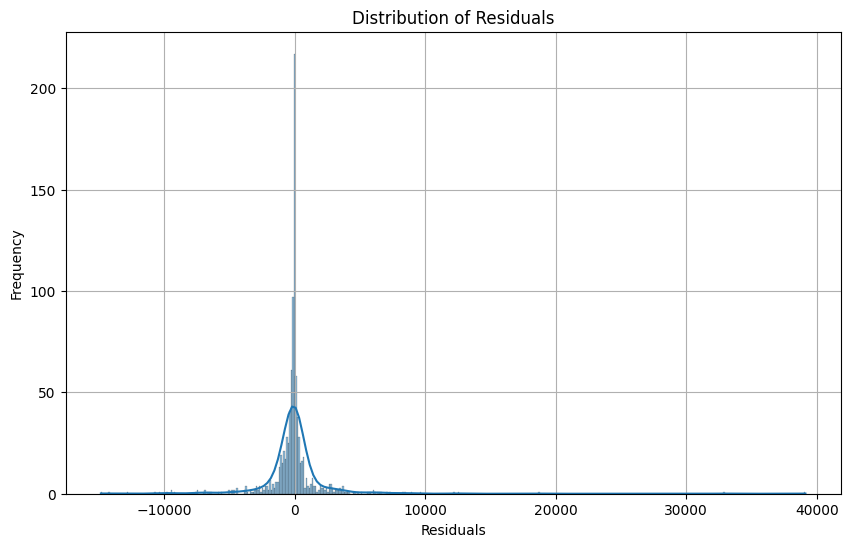

In [45]:
import seaborn as sns

# Plot distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

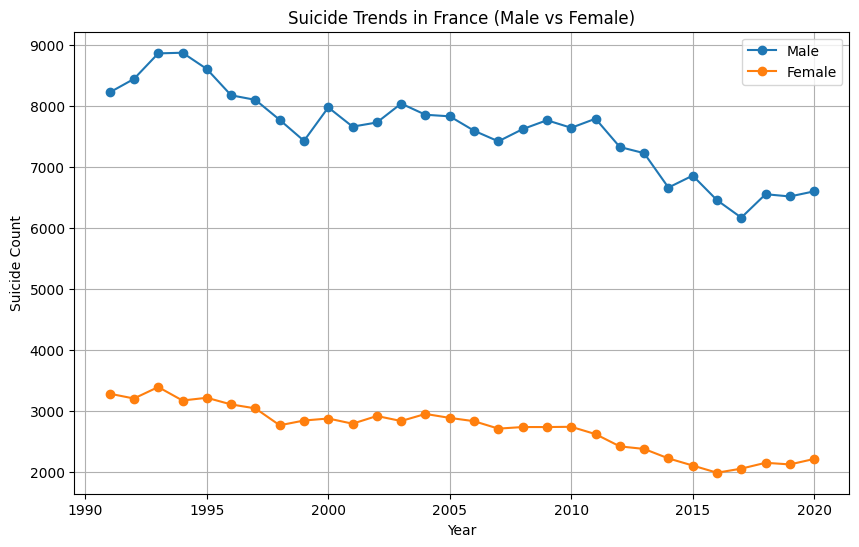

In [46]:
# Trend of Suicides Over Years for France
france_data = data[data['CountryCode'] == label_encoders['CountryCode'].transform(['FRA'])[0]]
france_data_male = france_data[france_data['Sex'] == label_encoders['Sex'].transform(['Male'])[0]]
france_data_female = france_data[france_data['Sex'] == label_encoders['Sex'].transform(['Female'])[0]]

plt.figure(figsize=(10, 6))
plt.plot(france_data_male['Year'], france_data_male['SuicideCount'], label='Male', marker='o')
plt.plot(france_data_female['Year'], france_data_female['SuicideCount'], label='Female', marker='o')
plt.xlabel('Year')
plt.ylabel('Suicide Count')
plt.title('Suicide Trends in France (Male vs Female)')
plt.legend()
plt.grid(True)
plt.show()

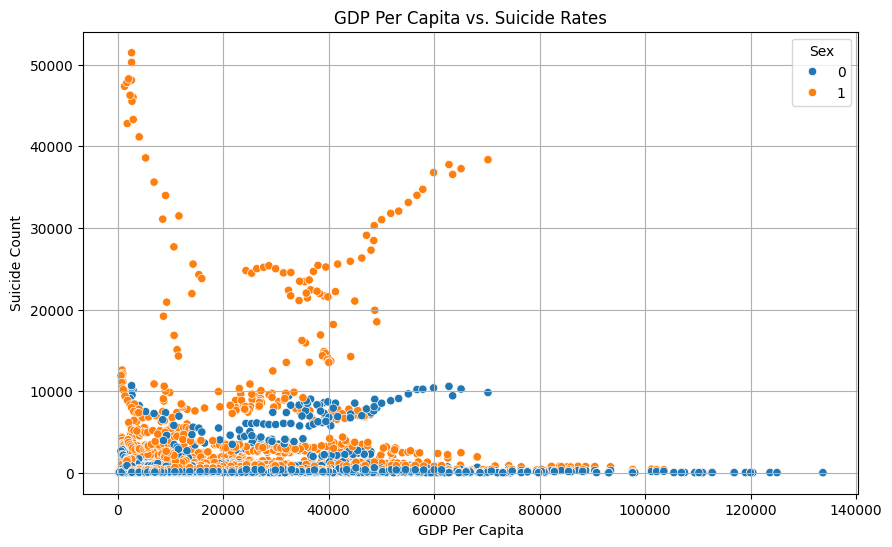

In [47]:
# GDP Per Capita vs. Suicide Rates
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['GDPPerCapita'], y=data['SuicideCount'], hue=data['Sex'])
plt.xlabel('GDP Per Capita')
plt.ylabel('Suicide Count')
plt.title('GDP Per Capita vs. Suicide Rates')
plt.grid(True)
plt.show()

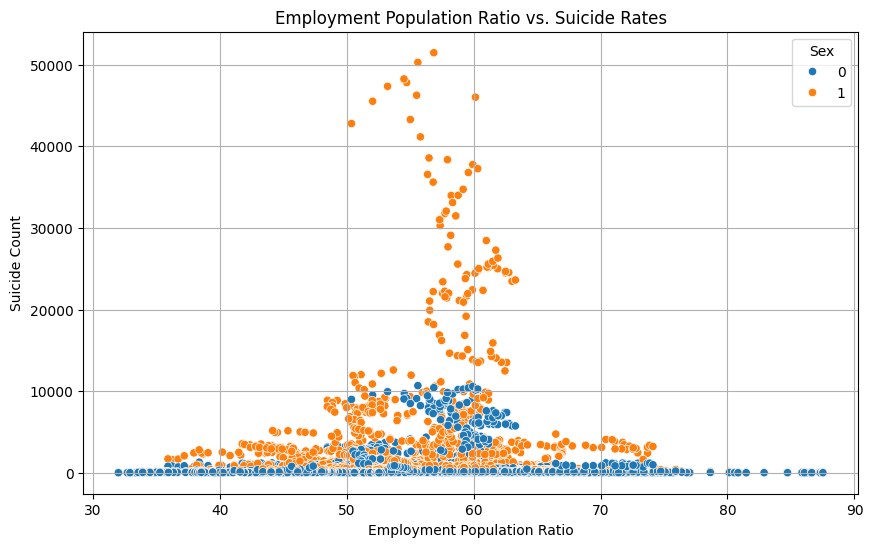

In [48]:
# Employment Population Ratio vs. Suicide Rates
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['EmploymentPopulationRatio'], y=data['SuicideCount'], hue=data['Sex'])
plt.xlabel('Employment Population Ratio')
plt.ylabel('Suicide Count')
plt.title('Employment Population Ratio vs. Suicide Rates')
plt.grid(True)
plt.show()

# Kmeans clustering

In [49]:
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

filter_data = data[(data['Year'] >= 2016) & (data['Year'] <= 2022)].copy()

# Selecting features for clustering
X = filter_data[['CountryCode', 'Year', 'Sex', 'GDPPerCapita', 'GNIPerCapita', 'InflationRate', 'EmploymentPopulationRatio', 'SuicideCount']]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [50]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=6, random_state=42)  # Let's assume we want to find 5 clusters
filter_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Add the cluster labels back to the original data
filter_data['Cluster'] = kmeans.labels_


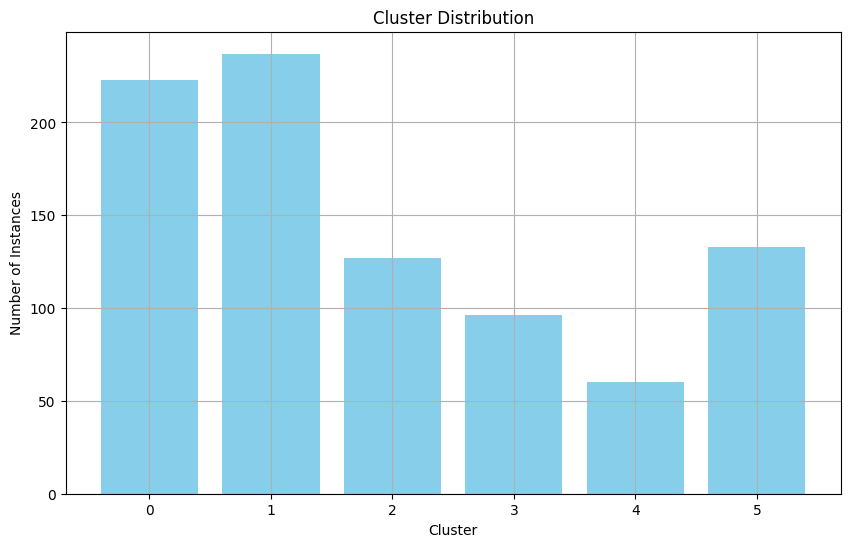

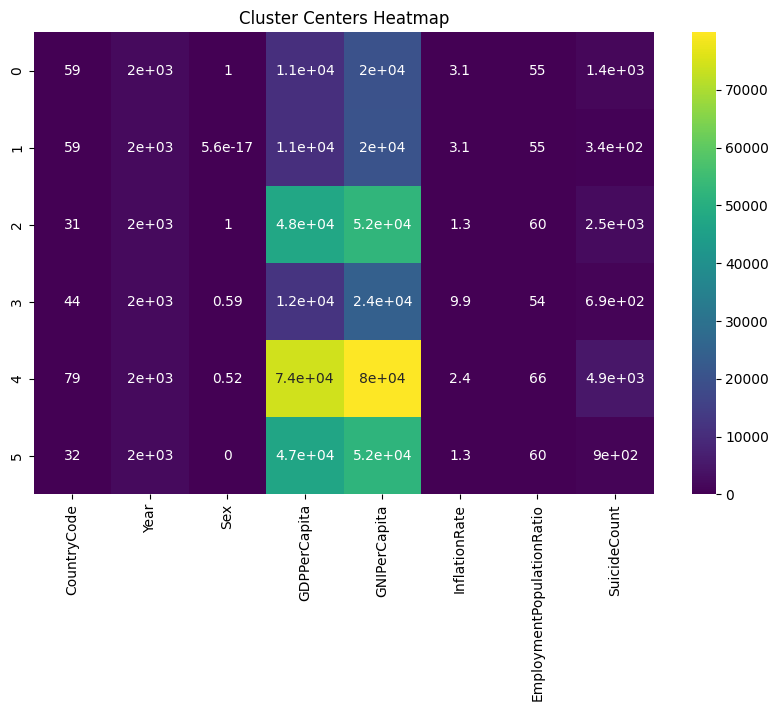

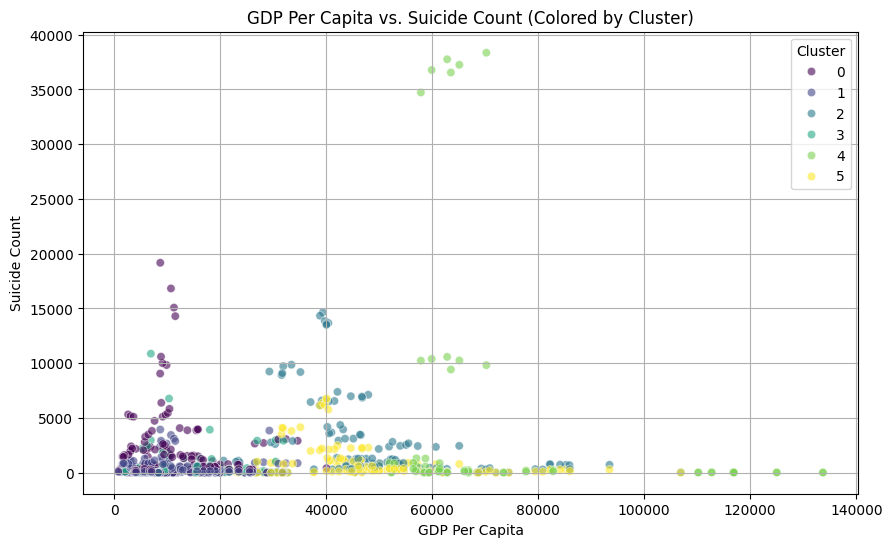

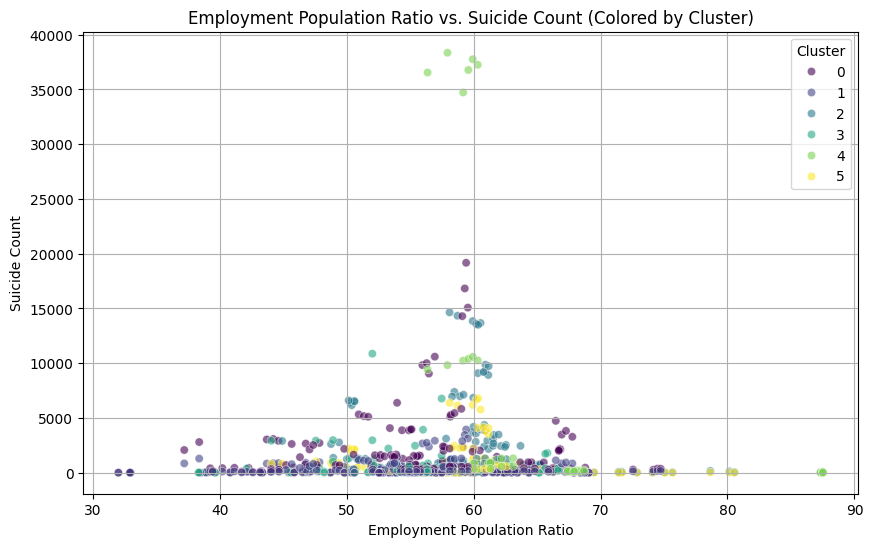

In [51]:
# Cluster Distribution
plt.figure(figsize=(10, 6))
cluster_counts = filter_data['Cluster'].value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Instances')
plt.title('Cluster Distribution')
plt.xticks(cluster_counts.index)
plt.grid(True)
plt.show()

# Cluster Centers Heatmap
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=X.columns)
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centers_df, annot=True, cmap='viridis')
plt.title('Cluster Centers Heatmap')
plt.show()

# Scatter Plot of Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filter_data['GDPPerCapita'], y=filter_data['SuicideCount'], hue=filter_data['Cluster'], palette='viridis', alpha=0.6)
plt.xlabel('GDP Per Capita')
plt.ylabel('Suicide Count')
plt.title('GDP Per Capita vs. Suicide Count (Colored by Cluster)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=filter_data['EmploymentPopulationRatio'], y=filter_data['SuicideCount'], hue=filter_data['Cluster'], palette='viridis', alpha=0.6)
plt.xlabel('Employment Population Ratio')
plt.ylabel('Suicide Count')
plt.title('Employment Population Ratio vs. Suicide Count (Colored by Cluster)')
plt.grid(True)
plt.show()


Mean of Features within each Cluster:
                Year       Sex  GDPPerCapita  GNIPerCapita  InflationRate  \
Cluster                                                                     
0        2017.538117  1.000000  10707.721664  20305.605381       3.109156   
1        2017.675105  0.000000  10647.651153  20384.092827       3.090507   
2        2018.330709  1.000000  47525.596761  52223.622047       1.295825   
3        2020.791667  0.593750  12154.410846  24142.395833       9.942221   
4        2019.383333  0.516667  74229.398759  79983.166667       2.412764   
5        2018.413534  0.000000  47105.107587  51997.142857       1.312469   

         EmploymentPopulationRatio  SuicideCount  
Cluster                                           
0                        55.417439   1387.255605  
1                        55.204321    343.312236  
2                        60.204370   2483.732283  
3                        54.170375    690.989583  
4                        66.290617   48

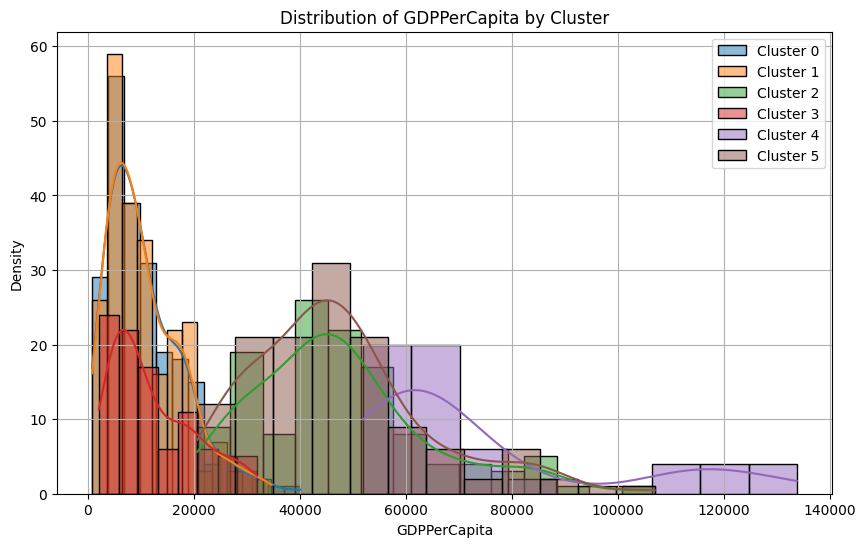

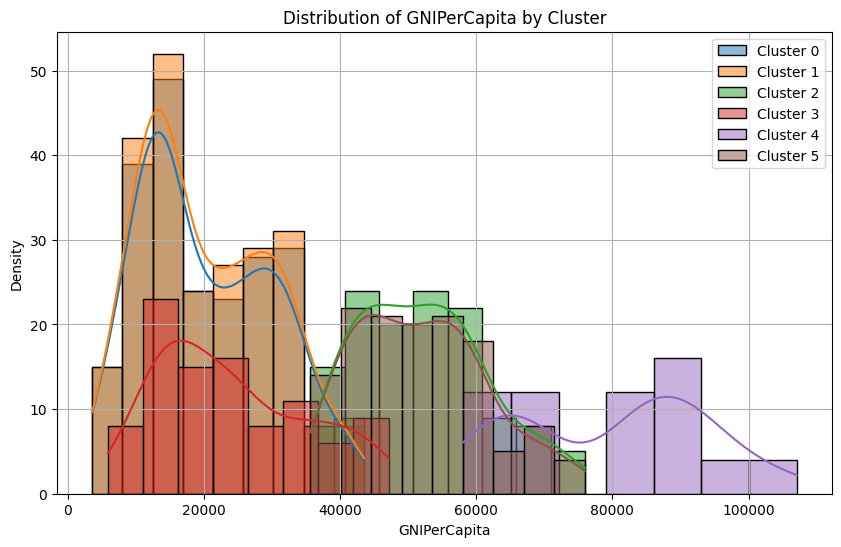

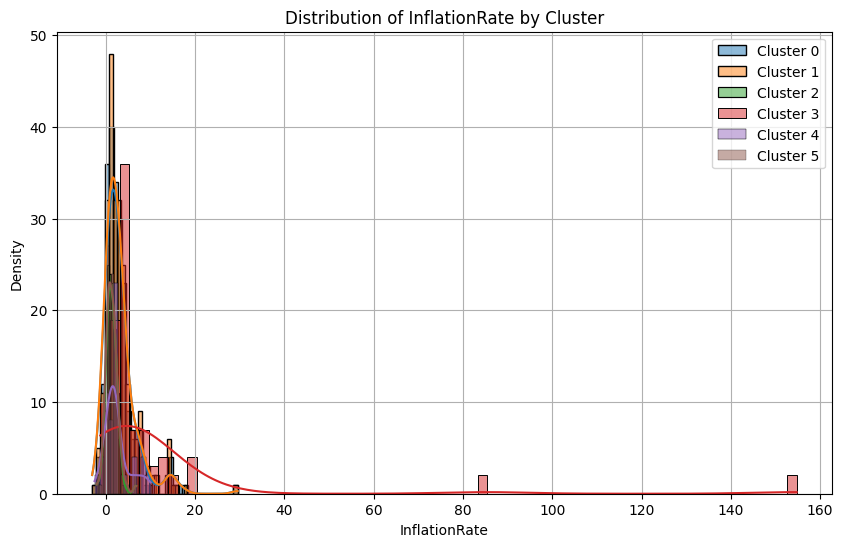

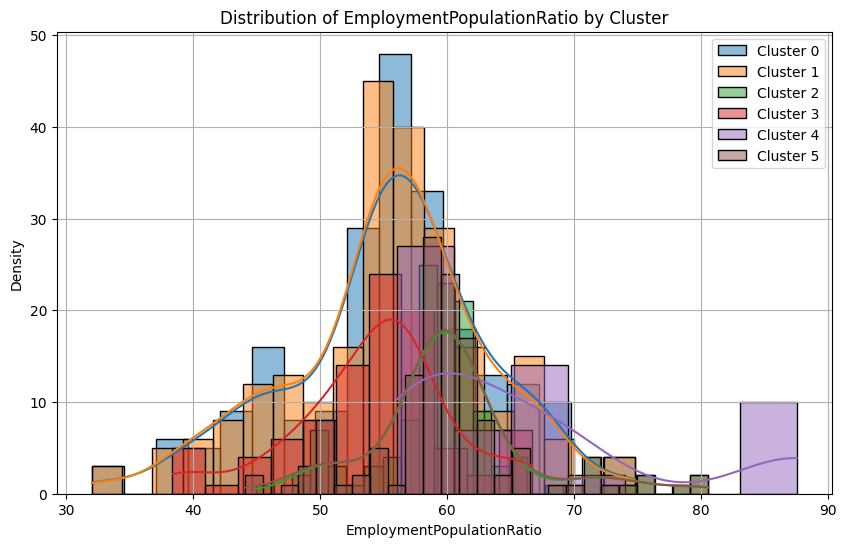

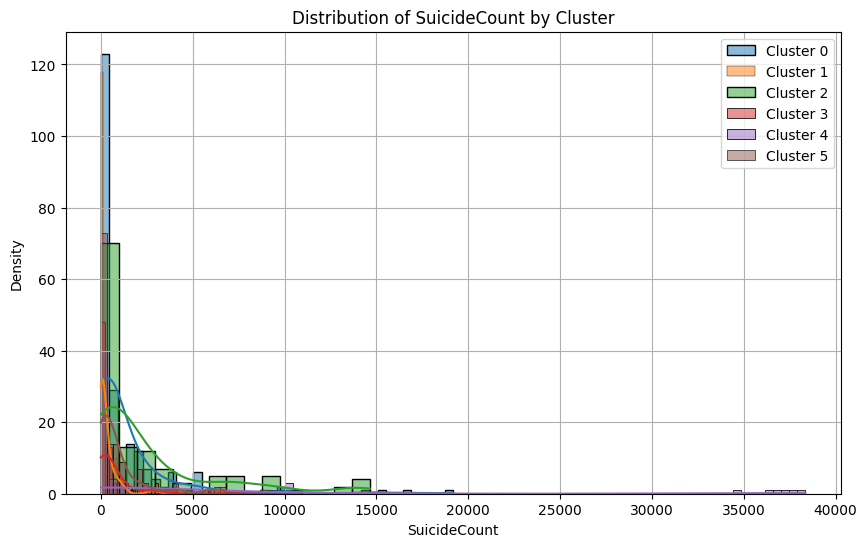

In [52]:
# Analysis: Mean/Median of Features (excluding non-numeric columns)
numeric_features = ['Year', 'Sex', 'GDPPerCapita', 'GNIPerCapita', 'InflationRate', 'EmploymentPopulationRatio', 'SuicideCount']

print("Mean of Features within each Cluster:")
print(filter_data.groupby('Cluster')[numeric_features].mean())

print("\nMedian of Features within each Cluster:")
print(filter_data.groupby('Cluster')[numeric_features].median())

# Analysis: Distribution of Features
features_to_plot = ['GDPPerCapita', 'GNIPerCapita', 'InflationRate', 'EmploymentPopulationRatio', 'SuicideCount']

for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    for cluster in range(6):
        sns.histplot(filter_data[filter_data['Cluster'] == cluster][feature], kde=True, label=f'Cluster {cluster}', alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Distribution of {feature} by Cluster')
    plt.legend()
    plt.grid(True)
    plt.show()



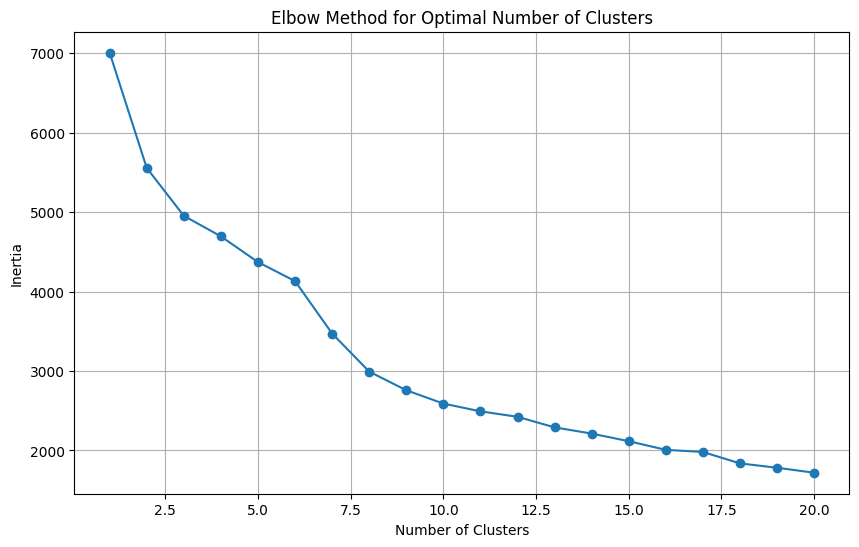

In [53]:
# Elbow Method for Optimal Numbers of Clusters

# Range of cluster numbers to try
n_clusters_range = range(1, 21)
inertia_values = []

# Iterate over the range of cluster numbers
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

# Plotting the elbow method
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


# PCA (with the data that was preprocessed at the Kmeans step)

In [54]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = filter_data['Cluster']


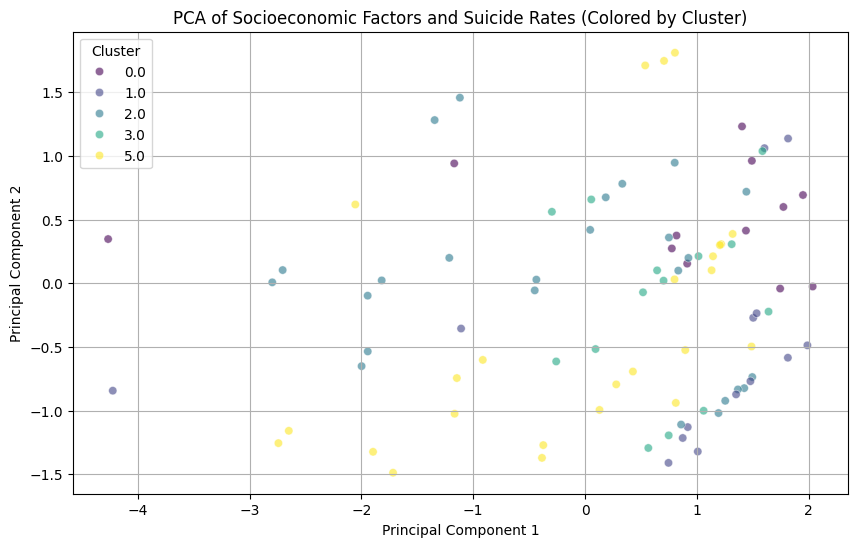

In [55]:
# Scatter Plot of PCA Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Socioeconomic Factors and Suicide Rates (Colored by Cluster)')
plt.grid(True)
plt.show()


Explained variance ratio of the first two principal components: [0.28741132 0.15290445]


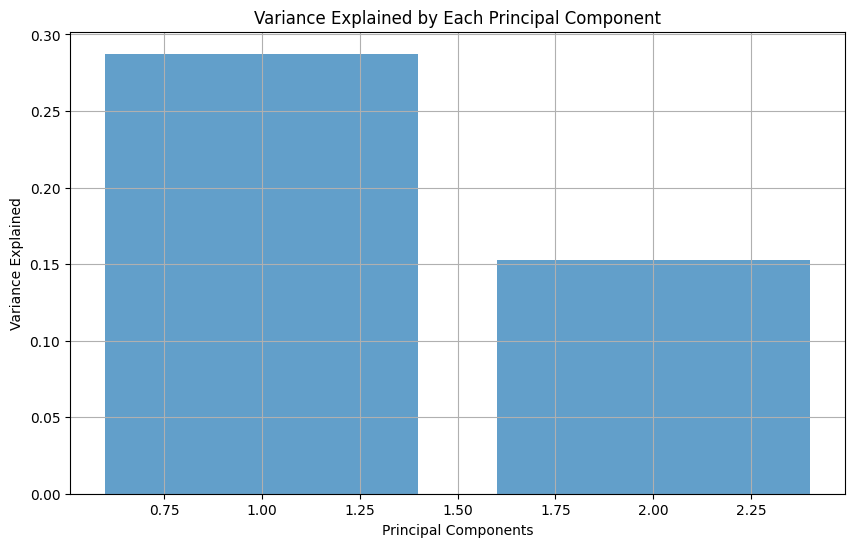

In [56]:
# Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio of the first two principal components: {explained_variance_ratio}")

# Bar plot of explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.grid(True)
plt.show()


# Information Retrieval

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./data_set/suicide_rates_socioeconomic_factors.csv')

data = data.dropna()

# Convert columns to numeric, catching exceptions explicitly
for column in data.columns:
    if data[column].dtype == 'object':
        try:
            data[column] = pd.to_numeric(data[column])
        except ValueError:
            pass 

# Sort countries by 'SuicideCount' (descending order)
sorted_indices = np.argsort(data['SuicideCount'].values)[::-1]

# Filter relevant indices based on 'RegionCode' being 'EU'
relevant_idx = np.where(data['RegionCode'] == 'EU')[0]

In [58]:
def precision_recall_at_k(k):
    top_k_indices = sorted_indices[:k] 
    top_k_relevant = np.sum(np.isin(top_k_indices, relevant_idx))
    precision = top_k_relevant / k  
    if len(relevant_idx) > 0:
        recall = top_k_relevant / len(relevant_idx) 
    else:
        recall = 0.0
    return precision, recall

In [59]:
def f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

In [60]:
# Calculate precision, recall, and F1-score at different values of k
ks = range(1, len(data) + 1)
precisions = []
recalls = []
f1_scores = []

for k in ks:
    precision, recall = precision_recall_at_k(k)
    f1 = f1_score(precision, recall)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    print(f"At k={k}: Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}")

At k=1: Precision=1.0000, Recall=0.0005, F1-score=0.0010
At k=2: Precision=1.0000, Recall=0.0010, F1-score=0.0020
At k=3: Precision=1.0000, Recall=0.0015, F1-score=0.0030
At k=4: Precision=1.0000, Recall=0.0020, F1-score=0.0040
At k=5: Precision=1.0000, Recall=0.0025, F1-score=0.0049
At k=6: Precision=1.0000, Recall=0.0030, F1-score=0.0059
At k=7: Precision=1.0000, Recall=0.0035, F1-score=0.0069
At k=8: Precision=1.0000, Recall=0.0040, F1-score=0.0079
At k=9: Precision=1.0000, Recall=0.0045, F1-score=0.0089
At k=10: Precision=1.0000, Recall=0.0050, F1-score=0.0099
At k=11: Precision=1.0000, Recall=0.0054, F1-score=0.0108
At k=12: Precision=1.0000, Recall=0.0059, F1-score=0.0118
At k=13: Precision=1.0000, Recall=0.0064, F1-score=0.0128
At k=14: Precision=0.9286, Recall=0.0064, F1-score=0.0128
At k=15: Precision=0.8667, Recall=0.0064, F1-score=0.0128
At k=16: Precision=0.8125, Recall=0.0064, F1-score=0.0128
At k=17: Precision=0.7647, Recall=0.0064, F1-score=0.0128
At k=18: Precision=0.72

In [61]:
def average_precision(precisions, recalls):
    ap = 0
    for k in range(1, len(precisions)):
        ap += precisions[k] * (recalls[k] - recalls[k - 1])
    return ap

ap = average_precision(precisions, recalls)

print("\nAverage Precision (AP):", ap)



Average Precision (AP): 0.523080133492963


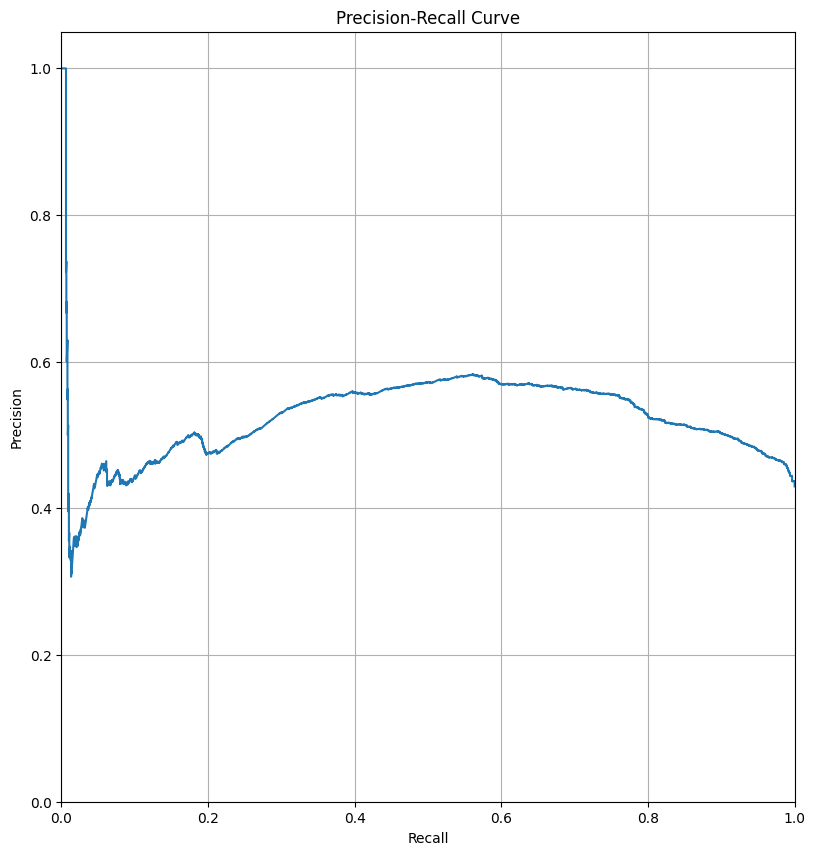

In [62]:
# Plot precision-recall curve
plt.figure(figsize=(10, 10))
plt.plot(recalls, precisions, linestyle='-')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
